# Retail Sales Forecasting: Exploratory Data Analysis and Time Series Preparation

## Overview
This Jupyter notebook performs an exploratory data analysis (EDA) and prepares the retail sales data for time series forecasting using ARIMA and SARIMA models. The dataset consists of daily sales data for 10 stores.

## Steps

1. **Data Loading and Initial Processing**
   - Load the dataset and parse dates.
   - Plot total monthly sales for each store to visualize trends.

2. **Data Transformation**
   - Convert the 'store' column to string type.
   - Save the processed dataset for further analysis in Tableau.
   - Add 'month' and 'year' columns to the dataframe.

3. **Data Resampling**
   - Separate sales data by store.
   - Resample the data to daily, weekly, and monthly frequencies for each store.
   - Compute the first-order difference to stationarize the data.

4. **Training and Testing Split**
   - Split the data into training (before 2017) and testing (2017) datasets.
   - Resample and stationarize the training and testing data similarly.

5. **Exploratory Analysis**
   - Plot the weekly and monthly sales for the first store.
   - Perform lag plots and correlation analysis to understand temporal dependencies.
   - Generate autocorrelation and partial autocorrelation plots to identify seasonality and lags.

6. **Stationarity Testing**
   - Use the Dickey-Fuller test to check for stationarity.
   - Plot rolling mean and standard deviation to visualize stationarity.

## Key Outputs
- Visualizations of sales trends and seasonality.
- Stationary time series data ready for modeling.
- Insights into the temporal dependencies and correlations within the sales data.

This notebook sets the foundation for building accurate time series forecasting models by thoroughly exploring and preparing the data.


In [9]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline


In [10]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

# Load the dataset with parsed dates
sales = pd.read_csv('train.csv', parse_dates=[0], date_parser=parser)

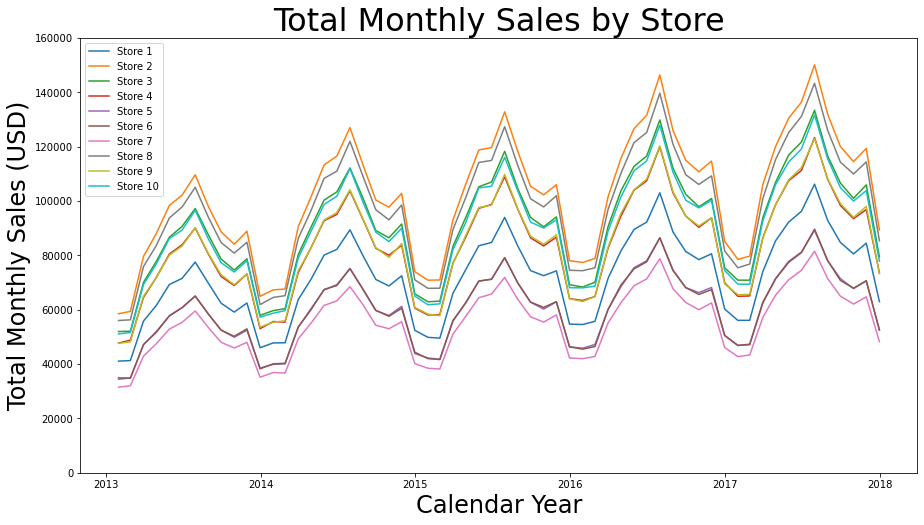

In [11]:
# Plot total monthly sales by store
plt.figure(figsize=(15, 8))
for i in range(1, 11):
    month_df = sales[sales.store == i].resample('M', on='date').sum()
    plt.plot(month_df.index, month_df.sales, label=f'Store {i}')
plt.legend(loc='upper left')
plt.title("Total Monthly Sales by Store", fontsize=32)
plt.ylabel("Total Monthly Sales (USD)", fontsize=24)
plt.xlabel("Calendar Year", fontsize=24)
plt.ylim(0, 160000)
plt.show()

In [12]:
# Convert store column to string type
sales['store'] = sales['store'].astype(str)
print(sales.dtypes)

date     datetime64[ns]
store            object
item              int64
sales             int64
dtype: object


In [13]:
sales.to_csv('tableau_train.csv', index=True)

In [14]:
# Display the first few rows of monthly sales data
print(month_df.head())

            store   item  sales
date                           
2013-01-31  15500  39525  51095
2013-02-28  14000  35700  51624
2013-03-31  15500  39525  69249
2013-04-30  15000  38250  76791
2013-05-31  15500  39525  86210


In [15]:
# Set 'date' column as the index
sales = sales.set_index('date')
sales['month'] = sales.index.month
sales['year'] = sales.index.year
print(len(sales))
print(sales.head())

913000
           store  item  sales  month  year
date                                      
2013-01-01     1     1     13      1  2013
2013-01-02     1     1     11      1  2013
2013-01-03     1     1     14      1  2013
2013-01-04     1     1     13      1  2013
2013-01-05     1     1     10      1  2013


In [16]:
# Initialize lists to store various dataframes
store_list = []
items_by_store = []
daily_sales_list = []
daily_diff_list = []
weekly_sales_list = []
weekly_diff_list = []
monthly_sales_list = []
monthly_diff_list = []

# Separate sales by store for the training set
for i in range(1, 11):
    store = sales[sales.store == str(i)]
    store_list.append(store)

# Create a separate dataframe to store non-sales columns for each store in our list
for store in store_list:
    sales_items = store.drop(columns='sales')
    items_by_store.append(sales_items)

# Convert our time series to daily stationary for each store
for store in store_list:
    daily_sales = store.resample('D').sum()
    daily_diff = daily_sales['sales'].diff(periods=1).dropna()
    daily_sales_list.append(daily_sales[['sales']])
    daily_diff_list.append(daily_diff)

# Convert our time series to weekly stationary for each store
for store in store_list:
    weekly_sales = store.resample('W').sum()
    weekly_diff = weekly_sales['sales'].diff(periods=1).dropna()
    weekly_sales_list.append(weekly_sales[['sales']])
    weekly_diff_list.append(weekly_diff)

# Convert our time series to monthly stationary for each store
for store in store_list:
    monthly_sales = store.resample('M').sum()
    monthly_diff = monthly_sales['sales'].diff(periods=1).dropna()
    monthly_sales_list.append(monthly_sales[['sales']])
    monthly_diff_list.append(monthly_diff)

In [17]:
# Print length and head of daily, weekly, and monthly sales for store 1
store1_daily_sales = daily_sales_list[0]
print(len(store1_daily_sales))
print(store1_daily_sales.head())

store1_weekly_sales = weekly_sales_list[0]
print(len(store1_weekly_sales))
print(store1_weekly_sales.head())

store1_monthly_sales = monthly_sales_list[0]
print(len(store1_monthly_sales))
print(store1_monthly_sales.head())

1826
            sales
date             
2013-01-01   1316
2013-01-02   1264
2013-01-03   1305
2013-01-04   1452
2013-01-05   1499
261
            sales
date             
2013-01-06   8449
2013-01-13   9289
2013-01-20   9287
2013-01-27   9229
2013-02-03   9826
60
            sales
date             
2013-01-31  41077
2013-02-28  41306
2013-03-31  55827
2013-04-30  61523
2013-05-31  69272


In [18]:
# Separate training and test datasets
sales_train = sales[sales.year < 2017]
print(len(sales_train))
print(sales_train.head())

730500
           store  item  sales  month  year
date                                      
2013-01-01     1     1     13      1  2013
2013-01-02     1     1     11      1  2013
2013-01-03     1     1     14      1  2013
2013-01-04     1     1     13      1  2013
2013-01-05     1     1     10      1  2013


In [19]:
sales_test = sales[sales.year == 2017]
print(len(sales_test))
print(sales_test.head())

182500
           store  item  sales  month  year
date                                      
2017-01-01     1     1     19      1  2017
2017-01-02     1     1     15      1  2017
2017-01-03     1     1     10      1  2017
2017-01-04     1     1     16      1  2017
2017-01-05     1     1     14      1  2017


In [20]:
# Restructure Train Data
store_train_list = []
items_by_store_train = []
daily_sales_train_list = []
daily_diff_train_list = []
weekly_sales_train_list = []
weekly_diff_train_list = []
monthly_sales_train_list = []
monthly_diff_train_list = []

# Separate sales by store for the training set
for i in range(1, 11):
    store = sales_train[sales_train.store == str(i)]
    store_train_list.append(store)

# Create a separate dataframe to store non-sales columns for each store in our list
for store in store_train_list:
    sales_items = store.drop(columns='sales')
    items_by_store_train.append(sales_items)

# Convert our time series to daily stationary for each store
for store in store_train_list:
    daily_sales = store.resample('D').sum()
    daily_diff = daily_sales['sales'].diff().dropna()
    daily_sales_train_list.append(daily_sales[['sales']])
    daily_diff_train_list.append(daily_diff)

# Convert our time series to weekly stationary for each store
for store in store_train_list:
    weekly_sales = store.resample('W').sum()
    weekly_diff = weekly_sales['sales'].diff().dropna()
    weekly_sales_train_list.append(weekly_sales[['sales']])
    weekly_diff_train_list.append(weekly_diff)

# Convert our time series to monthly stationary for each store
for store in store_train_list:
    monthly_sales = store.resample('M').sum()
    monthly_diff = monthly_sales['sales'].diff().dropna()
    monthly_sales_train_list.append(monthly_sales[['sales']])
    monthly_diff_train_list.append(monthly_diff)

In [21]:
# Print length and head of daily, weekly, and monthly training sales for store 1
store1_daily_sales_train = daily_sales_train_list[0]
print(len(store1_daily_sales_train))
print(store1_daily_sales_train.head())

store1_weekly_sales_train = weekly_sales_train_list[0]
print(len(store1_weekly_sales_train))
print(store1_weekly_sales_train.tail())

store1_monthly_sales_train = monthly_sales_train_list[0]
print(len(store1_monthly_sales_train))
print(store1_monthly_sales_train.head())

1461
            sales
date             
2013-01-01   1316
2013-01-02   1264
2013-01-03   1305
2013-01-04   1452
2013-01-05   1499
209
            sales
date             
2016-12-04  15428
2016-12-11  13528
2016-12-18  13586
2016-12-25  13640
2017-01-01  11166
48
            sales
date             
2013-01-31  41077
2013-02-28  41306
2013-03-31  55827
2013-04-30  61523
2013-05-31  69272


In [22]:
# Restructure Test Data
store_test_list = []
items_by_store_test = []
daily_sales_test_list = []
daily_diff_test_list = []
weekly_sales_test_list = []
weekly_diff_test_list = []
monthly_sales_test_list = []
monthly_diff_test_list = []

# Separate sales by store for the test set
for i in range(1, 11):
    store = sales_test[sales_test.store == str(i)]
    store_test_list.append(store)

# Create a separate dataframe to store non-sales columns for each store in our list
for store in store_test_list:
    sales_items = store.drop(columns='sales')
    items_by_store_test.append(sales_items)

# Convert our time series to daily stationary for each store
for store in store_test_list:
    daily_sales = store.resample('D').sum()
    daily_diff = daily_sales['sales'].diff().dropna()
    daily_sales_test_list.append(daily_sales[['sales']])
    daily_diff_test_list.append(daily_diff)

# Convert our time series to weekly stationary for each store
for store in store_test_list:
    weekly_sales = store.resample('W').sum()
    weekly_diff = weekly_sales['sales'].diff().dropna()
    weekly_sales_test_list.append(weekly_sales[['sales']])
    weekly_diff_test_list.append(weekly_diff)

# Convert our time series to monthly stationary for each store
for store in store_test_list:
    monthly_sales = store.resample('M').sum()
    monthly_diff = monthly_sales['sales'].diff().dropna()
    monthly_sales_test_list.append(monthly_sales[['sales']])
    monthly_diff_test_list.append(monthly_diff)

In [23]:
# Print length and head of daily, weekly, and monthly test sales for store 1
store1_daily_sales_test = daily_sales_test_list[0]
print(len(store1_daily_sales_test))
print(store1_daily_sales_test.head())

store1_weekly_sales_test = weekly_sales_test_list[0]
print(len(store1_weekly_sales_test))
print(store1_weekly_sales_test.head())

store1_monthly_sales_test = monthly_sales_test_list[0]
print(len(store1_monthly_sales_test))
print(store1_monthly_sales_test.head())

365
            sales
date             
2017-01-01   2155
2017-01-02   1441
2017-01-03   1635
2017-01-04   1713
2017-01-05   1858
53
            sales
date             
2017-01-01   2155
2017-01-08  12767
2017-01-15  12821
2017-01-22  12644
2017-01-29  12556
12
            sales
date             
2017-01-31  56086
2017-02-28  56098
2017-03-31  74037
2017-04-30  85338
2017-05-31  92248


<AxesSubplot:xlabel='date'>

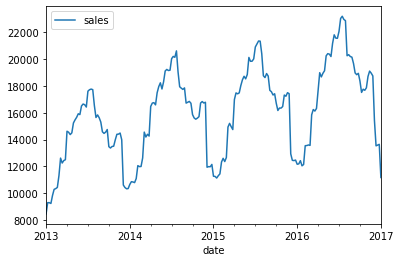

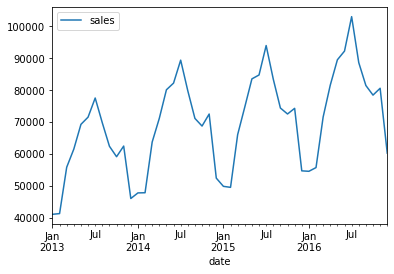

In [24]:
# Plot weekly and monthly sales for store 1
store1_weekly_sales_train.plot()
store1_monthly_sales_train.plot()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

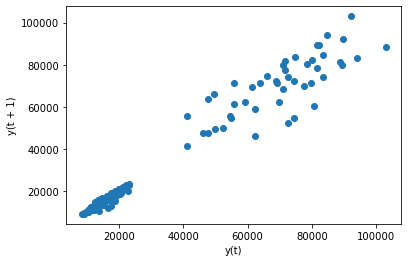

In [25]:
# Lag plot to show correlation between observation and lag=1 value
from pandas.plotting import lag_plot
lag_plot(store1_weekly_sales_train)
lag_plot(store1_monthly_sales_train)

In [26]:
# Correlation calculation for weekly and monthly sales with lag=1
series_train = store1_weekly_sales_train
values = pd.DataFrame(series_train.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.964212
t+1  0.964212  1.000000


In [27]:
# A strong positive correlation (0.80) between the observation and the lag=1 value.

series_train = store1_monthly_sales_train
values = pd.DataFrame(series_train.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.795018
t+1  0.795018  1.000000


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

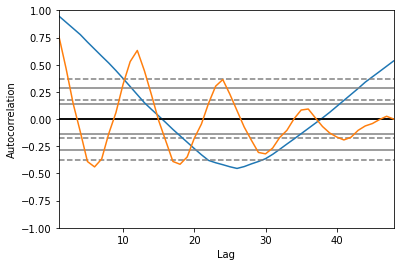

In [28]:
# Autocorrelation plot to show seasonal correlation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(store1_weekly_sales_train)
autocorrelation_plot(store1_monthly_sales_train)

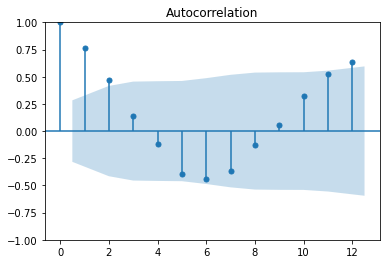

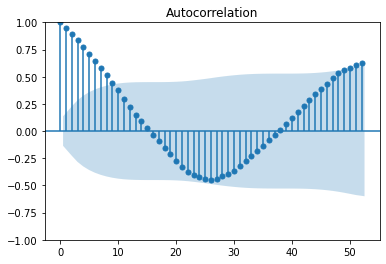

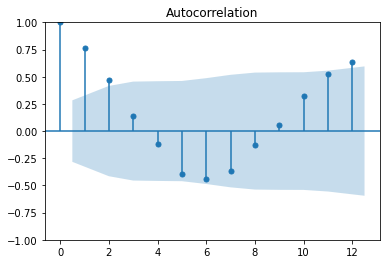

In [29]:
# Statsmodels version of autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(store1_weekly_sales_train, lags=52)
plot_acf(store1_monthly_sales_train, lags=12)

c:\Users\Rohan\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Rohan\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


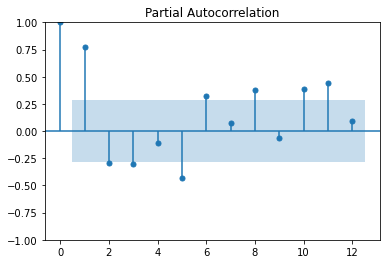

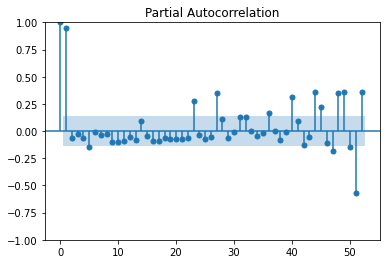

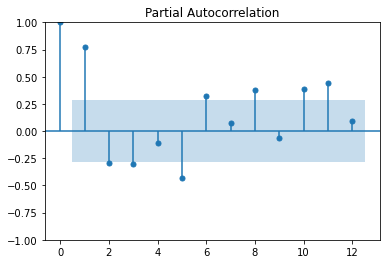

In [30]:
# Statsmodels version of partial autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(store1_weekly_sales_train, lags=52)
plot_pacf(store1_monthly_sales_train, lags=12)

In [32]:
# Check weekly and monthly deviations
print(store1_weekly_sales_train.sales.std())
print(store1_weekly_sales_train.sales.diff().std()) # d = 1 is the lowest 
print(store1_weekly_sales_train.sales.diff().diff().std()) 
print(store1_weekly_sales_train.sales.diff().diff().diff().std())

3312.472423028104
880.7899676366505
1126.6596000013171
1865.476810807349


In [33]:
(store1_monthly_sales_train.sales.std())
print(store1_monthly_sales_train.sales.diff().std()) # d = 1 is the lowest 
print(store1_monthly_sales_train.sales.diff().diff().std()) 
print(store1_monthly_sales_train.sales.diff().diff().diff().std())

9450.347150234458
11812.385971210486
19953.502774619992


In [34]:
# Define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dickey_fuller_test(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)
    # Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

Test Statistic           -3.001260
p-value                   0.034777
Lags Used                 4.000000
Observations Used       204.000000
Critical Value (1%)      -3.462818
Critical Value (5%)      -2.875815
Critical Value (10%)     -2.574379
dtype: float64


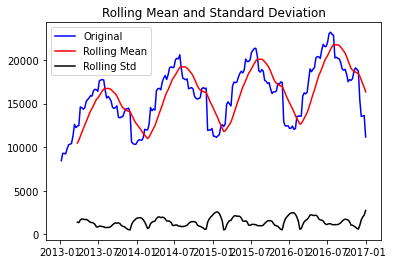

In [35]:
# P-value < 0.05 indicates that our data is stationary
dickey_fuller_test(store1_weekly_sales_train.sales)

Test Statistic          -0.883411
p-value                  0.793386
Lags Used               10.000000
Observations Used       37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


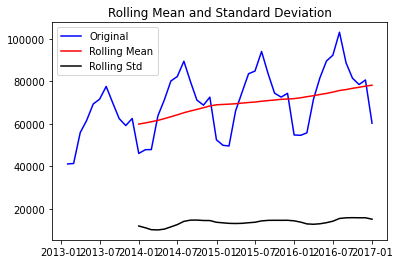

In [36]:
# P-value > 0.05 indicates that our data is non-stationary
dickey_fuller_test(store1_monthly_sales_train.sales)

Test Statistic          -0.883411
p-value                  0.793386
Lags Used               10.000000
Observations Used       37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


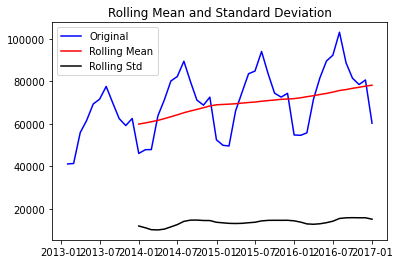

In [37]:
# P-value > 0.05 indicates that our data is non-stationary
dickey_fuller_test(store1_monthly_sales_train.sales)

In [39]:
# Stationarize the monthly sales data
stationary = store1_monthly_sales_train.sales.diff().dropna()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

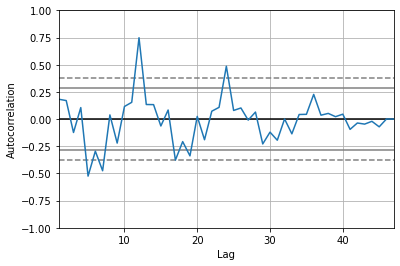

In [40]:
# Autocorrelation plot of stationarized training data
autocorrelation_plot(stationary)

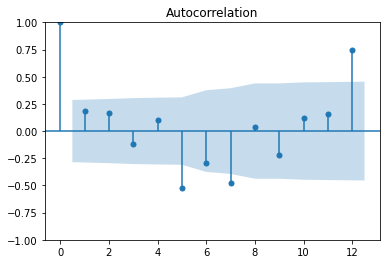

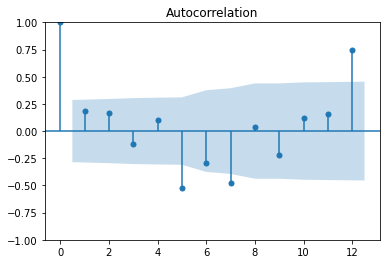

In [41]:
# Statsmodels version of autocorrelation plot of stationarized training data
plot_acf(stationary, lags=12)

c:\Users\Rohan\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


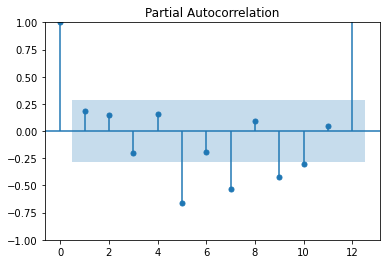

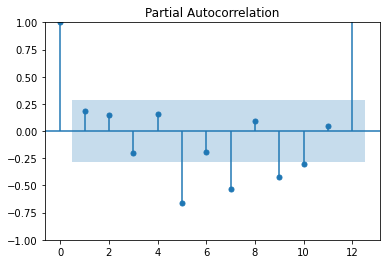

In [42]:
# Statsmodels version of partial autocorrelation plot of stationarized training data
plot_pacf(stationary, lags=12)

In [43]:
# Stationarize the weekly sales data
stationary = store1_weekly_sales_train.sales.diff().dropna()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

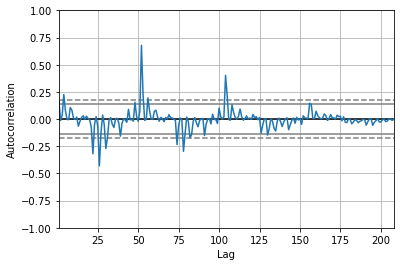

In [44]:
# Autocorrelation plot of stationarized training data
autocorrelation_plot(stationary)

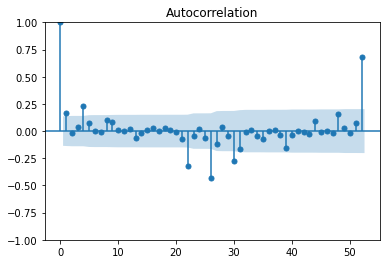

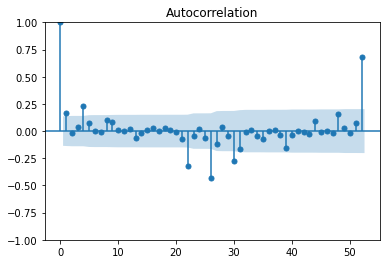

In [45]:
# Statsmodels version of autocorrelation plot of stationarized training data
plot_acf(stationary, lags=52)

c:\Users\Rohan\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


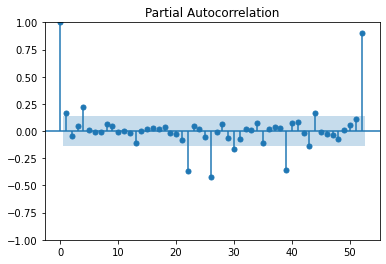

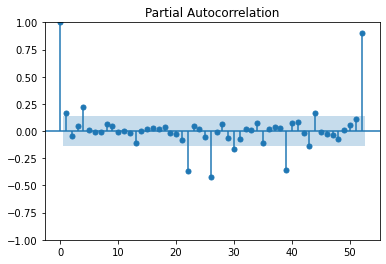

In [46]:
# Statsmodels version of partial autocorrelation plot of stationarized training data
plot_pacf(stationary, lags=52)